#### **Problem №3: Variational Integrators and Quaternions**

Consider the rotation of single rigid body with associated kinetic energy given by:

$$
    \mathcal{K} = \boldsymbol{\omega}^T \mathbf{I} \boldsymbol{\omega}
$$

with inertia matrix given derived with respect to principle axes as $\mathbf{I} = \text{diag}[I_x, I_y, I_z]$ and inertia parameters are given by:

Do the following:

* **[10 points]** Choose **unit quaternions** $\mathbf{q} \in \mathbb{S}^3$  to represent configuration of the system and define the **discrete Lagrangian** in this coordinates. 
  * Note: you may define the angular speed through quaternion derivative as follows: $\hat{\boldsymbol{\omega}} = 2\mathbf{q}^{*} \otimes \dot{\mathbf{q}}$,
where $\hat{\boldsymbol{\omega}} = [0, \boldsymbol{\omega}]$ and $\mathbf{q}^{*}$ is quaternion conjugate. 
* **[15 points]** Derive the **constrained discrete Euler-Lagrange** equations in momentum form. 

  * Simulate the system with sampling rate $dt = 0.01$ [s] starting from initial quaternion $\mathbf{q}(0) = [1,0,0,0]$ and initial velocities $\omega_1(0)= [6, 0.1, 0.1]$. 

  * Repeat the same for $\omega_2(0) = [0.1, 6, 0.1]$, $\omega_2(0) = [0.1, 0.1, 6]$, animate the trajectories (rotating frame) and discuss result. 

* **[10 points]** Plot the energy $\mathcal{K}(t)$, norm of momentum $\|\mathbf{p}(t)\|$ and norm of quaternion $\|\mathbf{q}(t)\|$. Compare the result with Euler integration (with and without quaternion normalization)

---

In [1]:
def quaternion_to_rm(Q):
    import numpy as np
    """
    Covert a quaternion into a full three-dimensional rotation matrix.

    Input
    :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 

    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    q0 = Q[0]
    q1 = Q[1]
    q2 = Q[2]
    q3 = Q[3]

    # First row of the rotation matrix
    r00 = q0**2 + q1 ** 2 - q2 ** 2 - q3 ** 2
    r01 = 2 * (q1 * q2 - q0 * q3)
    r02 = 2 * (q1 * q3 + q0 * q2)

    # Second row of the rotation matrix
    r10 = 2 * (q1 * q2 + q0 * q3)
    r11 = q0**2 - q1**2 + q2 ** 2 - q3**2
    r12 = 2 * (q2 * q3 - q0 * q1)

    # Third row of the rotation matrix
    r20 = 2 * (q1 * q3 - q0 * q2)
    r21 = 2 * (q2 * q3 + q0 * q1)
    r22 = q0**2 - q1**2 - q2**2 + q3**2

    # 3x3 rotation matrix
    rot_matrix = np.array([[r00, r01, r02],
                           [r10, r11, r12],
                           [r20, r21, r22]])

    return rot_matrix

In [2]:
import numpy as np


def quaternion_euler(I, q0, w0, dt, tspan, normalize=False):
    # print(dt)
    t = np.arange(tspan[0], tspan[-1]+dt, dt)

    x0 = np.hstack((q0, w0))
    xhist = np.zeros((7, len(t)))

    xhist[:, 0] = x0

    # qdothist = np.zeros((4, len(t)))
    # domegahist = np.zeros((3, len(t)))

    def qmult(q1, q2):
        L = np.array([
            [q1[0], -q1[1], -q1[2], -q1[3]],
            [q1[1], q1[0], -q1[3], q1[2]],
            [q1[2], q1[3], q1[0], -q1[1]],
            [q1[3], -q1[2], q1[1], q1[0]]
        ])

        return L @ q2
    
    def qconj(q):
        return np.array([q[0], -q[1], -q[2], -q[3]])

    def dynamics(state):
        q, omega = state[0:4], state[4:7]

        Omega = np.array([[0, -omega[0], -omega[1], -omega[2]],
                          [omega[0], 0, omega[2], -omega[1]],
                          [omega[1], -omega[2], 0, omega[0]],
                          [omega[2], omega[1], -omega[0], 0]])

        qdot = 0.5 * Omega @ q
        domega = np.linalg.inv(I) @ (- np.cross(omega, I @ omega))
        return np.hstack((qdot, domega))

    for k in range(len(t)-1):
        dx = dynamics(xhist[:, k])

        xhist[:, k+1] = xhist[:, k] + dt*dx

        if normalize:
            xhist[:, k+1] /= np.linalg.norm(xhist[:, k+1][0:4])

    qhist = xhist[0:4, :]
    whist = xhist[4:7, :]

    kinetic = []
    for k in range(len(t)):
        kinetic.append(0.5 * whist[:, k].T @ I @ whist[:, k])

    return t, qhist, I @ whist, np.array(kinetic)


In [3]:
import sympy as sp

J = sp.diag(0, 0.1, 0.2, 0.4)


def qmult(q1, q2):
    L = sp.Matrix([
        [q1[0], -q1[1], -q1[2], -q1[3]],
        [q1[1], q1[0], -q1[3], q1[2]],
        [q1[2], q1[3], q1[0], -q1[1]],
        [q1[3], -q1[2], q1[1], q1[0]]
    ])

    return L @ q2


def skew(v):
    return sp.Matrix([[0, -v[2], v[1]],
                      [v[2], 0, -v[0]],
                      [-v[1], v[0], 0]])


def qconj(q):
    return sp.Matrix([q[0], -q[1], -q[2], -q[3]])


def w(q, dq):
    return 2 * qmult(qconj(q), dq)


def kinetic(q, dq):
    return 1/2 * w(q, dq).T @ J @ w(q, dq)


q0 = sp.Matrix(sp.symbols(f'q_00, q_01, q_02, q_03'))
q1 = sp.Matrix(sp.symbols(f'q_10, q_11, q_12, q_13'))
momentum0 = sp.Matrix([sp.symbols(f'p0, p1, p2, p3')]).T
dt = sp.symbols(f'dt')

def constraint(q):
    return (0.5 * (q[0] ** 2 + q[1] ** 2 + q[2] ** 2 + q[3] ** 2 - 1)).diff(q)


constr = sp.symbols(f'$\lambda$')
q0


Matrix([
[q_00],
[q_01],
[q_02],
[q_03]])

In [4]:
def discrete_lagrangian(q1, q2, dt):
    # q1 - q_k
    # q2 - q_k+1
    return dt * (kinetic((q1 + q2) / 2, (q2 - q1) / dt)[0])


discrete_lagrangian(q0, q1, dt)


dt*((0.1*(-q_00 + q_10)*(-q_01/2 - q_11/2)/dt + 0.1*(q_00/2 + q_10/2)*(-q_01 + q_11)/dt + 0.1*(-q_02 + q_12)*(q_03/2 + q_13/2)/dt + 0.1*(-q_02/2 - q_12/2)*(-q_03 + q_13)/dt)*(2*(-q_00 + q_10)*(-q_01/2 - q_11/2)/dt + 2*(q_00/2 + q_10/2)*(-q_01 + q_11)/dt + 2*(-q_02 + q_12)*(q_03/2 + q_13/2)/dt + 2*(-q_02/2 - q_12/2)*(-q_03 + q_13)/dt) + (0.2*(-q_00 + q_10)*(-q_02/2 - q_12/2)/dt + 0.2*(q_00/2 + q_10/2)*(-q_02 + q_12)/dt + 0.2*(-q_01 + q_11)*(-q_03/2 - q_13/2)/dt + 0.2*(q_01/2 + q_11/2)*(-q_03 + q_13)/dt)*(2*(-q_00 + q_10)*(-q_02/2 - q_12/2)/dt + 2*(q_00/2 + q_10/2)*(-q_02 + q_12)/dt + 2*(-q_01 + q_11)*(-q_03/2 - q_13/2)/dt + 2*(q_01/2 + q_11/2)*(-q_03 + q_13)/dt) + (0.4*(-q_00 + q_10)*(-q_03/2 - q_13/2)/dt + 0.4*(q_00/2 + q_10/2)*(-q_03 + q_13)/dt + 0.4*(-q_01 + q_11)*(q_02/2 + q_12/2)/dt + 0.4*(-q_01/2 - q_11/2)*(-q_02 + q_12)/dt)*(2*(-q_00 + q_10)*(-q_03/2 - q_13/2)/dt + 2*(q_00/2 + q_10/2)*(-q_03 + q_13)/dt + 2*(-q_01 + q_11)*(q_02/2 + q_12/2)/dt + 2*(-q_01/2 - q_11/2)*(-q_02 + q_12)/

In [5]:
def momentum(q, dq):
    return kinetic(q, dq)[0].diff(dq)

In [6]:
# momentum residual is used to calculate q_{k+1} given q_k and p_k
# in current example q_1 should be found given q_0 and p_0
# p_k + D1 L(q_k, q_k+1) = constraint(q_k)
momentum_residual = momentum0 + sp.Matrix([discrete_lagrangian(q0, q1, dt)]).jacobian(q0).T

momentum_residual.shape

(4, 1)

In [7]:
# given q_0 and q_1 find p_1
# p_k+1 = D2 L(q_k, q_k+1)
momentum_next = sp.Matrix([discrete_lagrangian(q0, q1, dt)]).jacobian(q1).T

momentum_next.shape

(4, 1)

In [8]:
dq = sp.Matrix(sp.symbols(f'dq_0, dq_1, dq_2, dq_3'))

numerical = dict(
    momentum_residual = sp.lambdify([q0, q1, momentum0, dt], momentum_residual),
    momentum_next = sp.lambdify([q0, q1, dt], momentum_next),
    constraint = sp.lambdify([q0, dt], constraint(q0)),
    qmult = sp.lambdify([q0, q1], qmult(q0, q1)),
    kinetic = sp.lambdify([q0, dq], kinetic(q0, dq)[0]),
)

numerical['momentum'] = sp.lambdify([q0, dq], momentum(q0, dq))


In [9]:
from scipy.optimize import fsolve
import numpy as np
from time import perf_counter


def qvi_quaternion(I, q0, w0, dt, tspan):
    t = np.arange(tspan[0], tspan[-1]+dt, dt)
    N = len(t)
    position = np.zeros((N, 5))
    momentum = np.zeros((N, 4))
    position[0] = np.array([*q0, 0])
    # momentum[0] = I @ np.array([0, *w0])
    # print(q0.T @ np.array([0, *w0]))
    dq0 = 1/2 * numerical['qmult'](q0, np.array([0, *w0]))
    # print(q0, dq0)
    momentum[0] = numerical['momentum'](q0, dq0).flatten()
    # print(momentum[0])

    def constrained_residual(x, q0, p0, dt):
        # x = q1 because we are solving for q1

        # q0 is 5x1, take only the first 4 elements
        constr = x[4]
        q0 = q0[:4]
        x = x[:4]

        residual = numerical['momentum_residual'](
            q0, x, p0, dt) + numerical['constraint'](q0, dt) * constr
        residual = np.array(residual.T.flatten())

        return np.array([
            residual[0],
            residual[1],
            residual[2],
            residual[3],
            x.T @ x - 1,
        ], dtype=np.float64)

    def constrained_next(q0, q1, dt):
        q0 = q0[:4]
        q1 = q1[:4]

        res = numerical['momentum_next'](q0, q1, dt).T.flatten()

        return res

    t1 = perf_counter()
    for i in range(1, N):
        q_next = fsolve(constrained_residual,
                        position[i-1], args=(position[i-1], momentum[i-1], dt))
        position[i] = q_next
        momentum[i] = constrained_next(position[i-1], position[i], dt)

    t2 = perf_counter()
    print(f'elapsed time for simulation of {N} steps: {(t2-t1)} [s]')
    print(f'average time per step: {(t2-t1)/N} [s]')

    qhist = position[:, :4].T

    kinetic = np.zeros(N)
    for i in range(1, N):
        dq = (qhist[:, i] - qhist[:, i-1]) / dt
        kinetic[i] = numerical['kinetic'](qhist[:, i], dq)
    kinetic[0] = kinetic[1]

    return t, qhist, momentum.T, kinetic


## Simulate with dt = 0.01s, q0 = [1, 0, 0, 0], w1(0) = [6, 0.1, 0.1]

In [10]:
# simulate the system

tspan = (0, 10)
dt = 0.01
I = np.diag([0.1, 0.2, 0.4])
Ivi = np.diag([0, 0.1, 0.2, 0.4])
w0 = np.array([6, 0.1, 0.1])
q0 = np.array([1, 0, 0, 0])

t1euler, q1euler, p1euler, k1euler = quaternion_euler(I, q0, w0, dt, tspan)
t1norm, q1norm, p1norm, k1norm = quaternion_euler(I, q0, w0, dt, tspan, normalize=True)
t1vi, q1vi, p1vi, k1vi = qvi_quaternion(Ivi, q0, w0, dt, tspan)


elapsed time for simulation of 1001 steps: 8.320715622001444 [s]
average time per step: 0.008312403218782662 [s]


In [11]:
def save(name, time, quaternions):
    # save the results: [time, r00, r01, r02, r10, r11, r12, r20, r21, r22]
    rms = []
    for i in range(len(time)):
        rm = quaternion_to_rm(quaternions[:, i])
        rms.append(np.array([time[i], *rm.flatten()]))

    rms = np.array(rms)

    import json
    with open(f'data/{name}.json', 'w') as f:
        json.dump(rms.tolist(), f)

save('task1_1_qvi', t1vi, q1vi)
save('task1_1_euler', t1euler, q1euler)
save('task1_1_norm', t1norm, q1norm)


Text(0, 0.5, 'Quaternion')

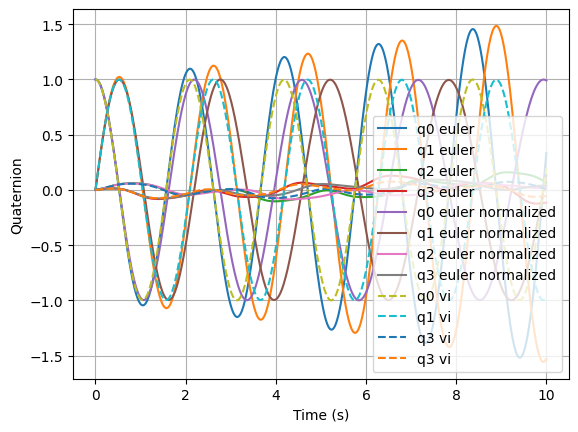

In [12]:
# plot the results

import matplotlib.pyplot as plt

plt.figure()
plt.plot(t1euler, q1euler[0, :], label='q0 euler')
plt.plot(t1euler, q1euler[1, :], label='q1 euler')
plt.plot(t1euler, q1euler[2, :], label='q2 euler')
plt.plot(t1euler, q1euler[3, :], label='q3 euler')

plt.plot(t1norm, q1norm[0, :], label='q0 euler normalized')
plt.plot(t1norm, q1norm[1, :], label='q1 euler normalized')
plt.plot(t1norm, q1norm[2, :], label='q2 euler normalized')
plt.plot(t1norm, q1norm[3, :], label='q3 euler normalized')

plt.plot(t1vi, q1vi[0,:], '--', label='q0 vi')
plt.plot(t1vi, q1vi[1,:], '--', label='q1 vi')
plt.plot(t1vi, q1vi[2,:], '--', label='q3 vi')
plt.plot(t1vi, q1vi[3,:], '--', label='q3 vi')
plt.legend()
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Quaternion')

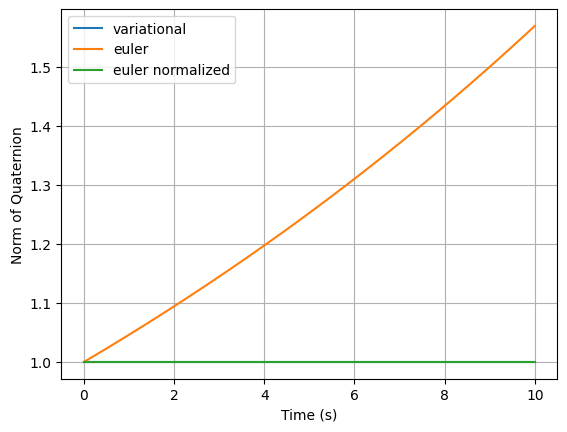

In [13]:
# plot norm of quaternion
plt.figure()
plt.plot(t1vi, np.sqrt(np.sum(q1vi[:4, :]**2, axis=0)), label='variational')
plt.plot(t1euler, np.sqrt(np.sum(q1euler[:4, :]**2, axis=0)), label='euler')
plt.plot(t1norm, np.sqrt(np.sum(q1norm[:4, :]**2, axis=0)), label='euler normalized')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Norm of Quaternion')
plt.grid()

Text(0, 0.5, 'Norm of Momentum')

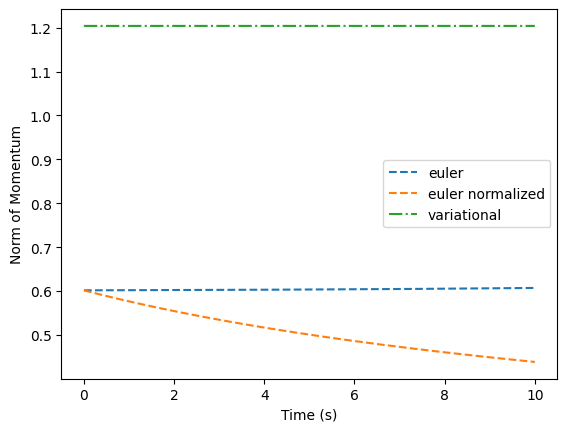

In [14]:
# plot momentum norm 
plt.figure()
plt.plot(t1euler, np.sqrt(np.sum(p1euler**2, axis=0)), '--', label='euler')
plt.plot(t1euler, np.sqrt(np.sum(p1norm**2, axis=0)), '--', label='euler normalized')
plt.plot(t1vi, np.sqrt(np.sum(p1vi**2, axis=0)), '-.', label='variational')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Norm of Momentum')

Text(0, 0.5, 'Kinetic energy')

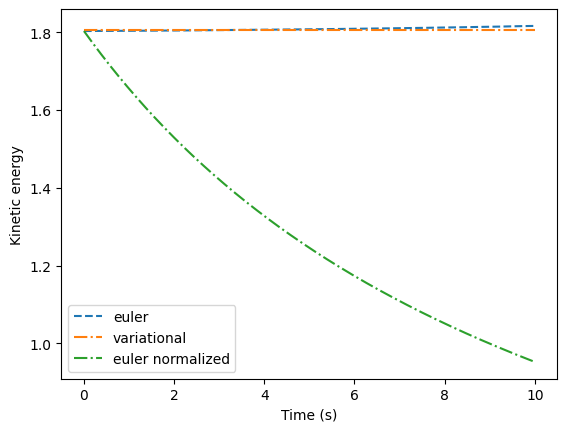

In [15]:
# plot kinetic energy
plt.figure()
plt.plot(t1euler, k1euler, '--', label='euler')
plt.plot(t1vi, k1vi, '-.', label='variational')
plt.plot(t1euler, k1norm, '-.', label='euler normalized')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Kinetic energy')

## Simulate with dt = 0.01s, q0 = [1, 0, 0, 0], w1(0) = [0.1, 6, 0.1]

In [28]:
# simulate the system

tspan = (0, 10)
dt = 0.01
I = np.diag([0.1, 0.2, 0.4])
Ivi = np.diag([0, 0.1, 0.2, 0.4])
w0 = np.array([0.1, 6, 0.1])
q0 = np.array([1, 0, 0, 0])

t1euler, q1euler, p1euler, k1euler = quaternion_euler(I, q0, w0, dt, tspan)
t1norm, q1norm, p1norm, k1norm = quaternion_euler(I, q0, w0, dt, tspan, normalize=True)
t1vi, q1vi, p1vi, k1vi = qvi_quaternion(Ivi, q0, w0, dt, tspan)

save('task1_2_qvi', t1vi, q1vi)
save('task1_2_euler', t1euler, q1euler)
save('task1_2_norm', t1norm, q1norm)


elapsed time for simulation of 1001 steps: 6.5482475950120715 [s]
average time per step: 0.006541705889122949 [s]


Text(0, 0.5, 'Quaternion')

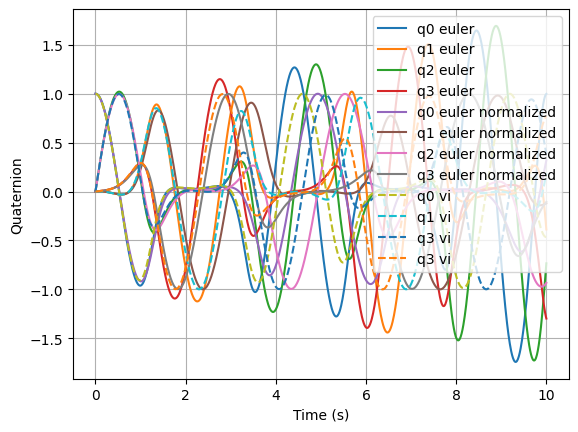

In [29]:
# plot the results

import matplotlib.pyplot as plt

plt.figure()
plt.plot(t1euler, q1euler[0, :], label='q0 euler')
plt.plot(t1euler, q1euler[1, :], label='q1 euler')
plt.plot(t1euler, q1euler[2, :], label='q2 euler')
plt.plot(t1euler, q1euler[3, :], label='q3 euler')

plt.plot(t1norm, q1norm[0, :], label='q0 euler normalized')
plt.plot(t1norm, q1norm[1, :], label='q1 euler normalized')
plt.plot(t1norm, q1norm[2, :], label='q2 euler normalized')
plt.plot(t1norm, q1norm[3, :], label='q3 euler normalized')

plt.plot(t1vi, q1vi[0,:], '--', label='q0 vi')
plt.plot(t1vi, q1vi[1,:], '--', label='q1 vi')
plt.plot(t1vi, q1vi[2,:], '--', label='q3 vi')
plt.plot(t1vi, q1vi[3,:], '--', label='q3 vi')

plt.legend()
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Quaternion')

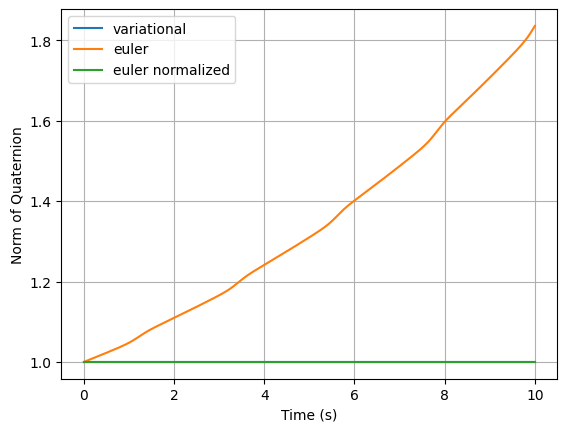

In [18]:
# plot norm of quaternion
plt.figure()
plt.plot(t1vi, np.sqrt(np.sum(q1vi[:4, :]**2, axis=0)), label='variational')
plt.plot(t1euler, np.sqrt(np.sum(q1euler[:4, :]**2, axis=0)), label='euler')
plt.plot(t1norm, np.sqrt(np.sum(q1norm[:4, :]**2, axis=0)), label='euler normalized')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Norm of Quaternion')
plt.grid()

Text(0, 0.5, 'Norm of Momentum')

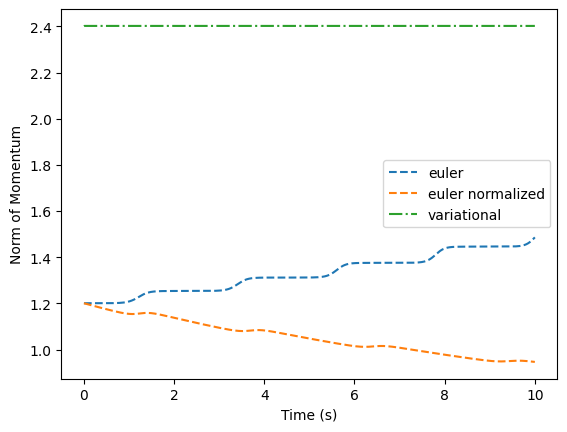

In [19]:
# plot momentum norm 
plt.figure()
plt.plot(t1euler, np.sqrt(np.sum(p1euler**2, axis=0)), '--', label='euler')
plt.plot(t1euler, np.sqrt(np.sum(p1norm**2, axis=0)), '--', label='euler normalized')
plt.plot(t1vi, np.sqrt(np.sum(p1vi**2, axis=0)), '-.', label='variational')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Norm of Momentum')

Text(0, 0.5, 'Kinetic energy')

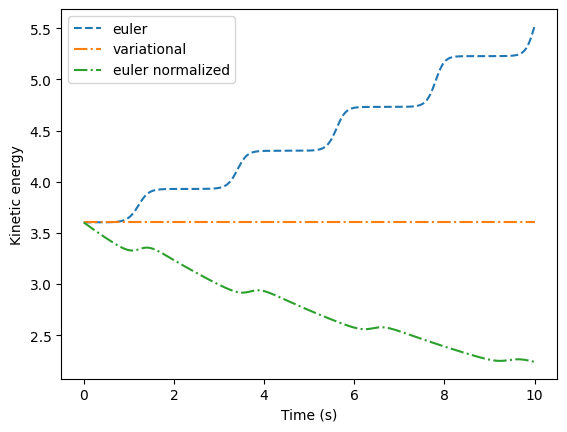

In [20]:
# plot kinetic energy
plt.figure()
plt.plot(t1euler, k1euler, '--', label='euler')
plt.plot(t1vi, k1vi, '-.', label='variational')
plt.plot(t1euler, k1norm, '-.', label='euler normalized')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Kinetic energy')

## Simulate with dt = 0.01s, q0 = [1, 0, 0, 0], w1(0) = [0.1, 0.1, 6]

In [21]:
# simulate the system

tspan = (0, 10)
dt = 0.01
I = np.diag([0.1, 0.2, 0.4])
Ivi = np.diag([0, 0.1, 0.2, 0.4])
w0 = np.array([0.1, 0.1, 6])
q0 = np.array([1, 0, 0, 0])

t1euler, q1euler, p1euler, k1euler = quaternion_euler(I, q0, w0, dt, tspan)
t1norm, q1norm, p1norm, k1norm = quaternion_euler(I, q0, w0, dt, tspan, normalize=True)
t1vi, q1vi, p1vi, k1vi = qvi_quaternion(Ivi, q0, w0, dt, tspan)

save('task1_3_qvi', t1vi, q1vi)
save('task1_3_euler', t1euler, q1euler)
save('task1_3_norm', t1norm, q1norm)


elapsed time for simulation of 1001 steps: 9.455013024009531 [s]
average time per step: 0.009445567456552978 [s]


Text(0, 0.5, 'Quaternion')

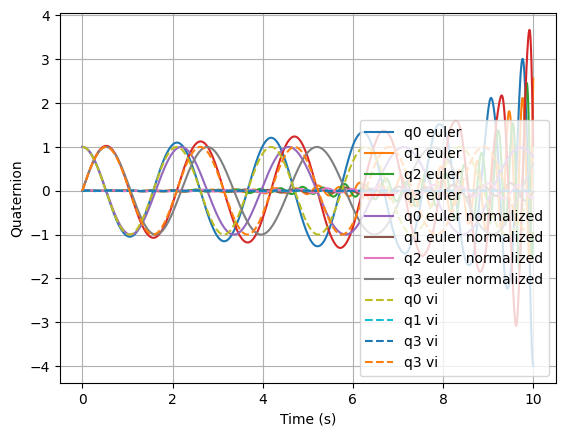

In [22]:
# plot the results

import matplotlib.pyplot as plt

plt.figure()
plt.plot(t1euler, q1euler[0, :], label='q0 euler')
plt.plot(t1euler, q1euler[1, :], label='q1 euler')
plt.plot(t1euler, q1euler[2, :], label='q2 euler')
plt.plot(t1euler, q1euler[3, :], label='q3 euler')

plt.plot(t1norm, q1norm[0, :], label='q0 euler normalized')
plt.plot(t1norm, q1norm[1, :], label='q1 euler normalized')
plt.plot(t1norm, q1norm[2, :], label='q2 euler normalized')
plt.plot(t1norm, q1norm[3, :], label='q3 euler normalized')

plt.plot(t1vi, q1vi[0,:], '--', label='q0 vi')
plt.plot(t1vi, q1vi[1,:], '--', label='q1 vi')
plt.plot(t1vi, q1vi[2,:], '--', label='q3 vi')
plt.plot(t1vi, q1vi[3,:], '--', label='q3 vi')
plt.legend()
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Quaternion')

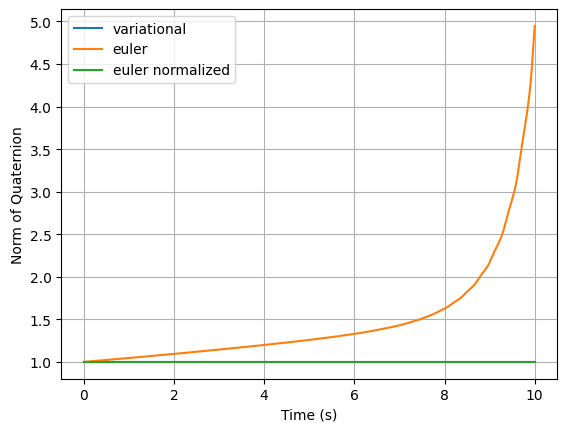

In [23]:
# plot norm of quaternion
plt.figure()
plt.plot(t1vi, np.sqrt(np.sum(q1vi[:4, :]**2, axis=0)), label='variational')
plt.plot(t1euler, np.sqrt(np.sum(q1euler[:4, :]**2, axis=0)), label='euler')
plt.plot(t1norm, np.sqrt(np.sum(q1norm[:4, :]**2, axis=0)), label='euler normalized')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Norm of Quaternion')
plt.grid()

Text(0, 0.5, 'Norm of Momentum')

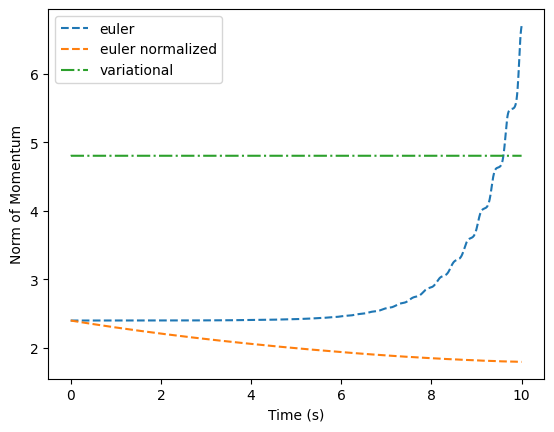

In [24]:
# plot momentum norm 
plt.figure()
plt.plot(t1euler, np.sqrt(np.sum(p1euler**2, axis=0)), '--', label='euler')
plt.plot(t1euler, np.sqrt(np.sum(p1norm**2, axis=0)), '--', label='euler normalized')
plt.plot(t1vi, np.sqrt(np.sum(p1vi**2, axis=0)), '-.', label='variational')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Norm of Momentum')

Text(0, 0.5, 'Kinetic energy')

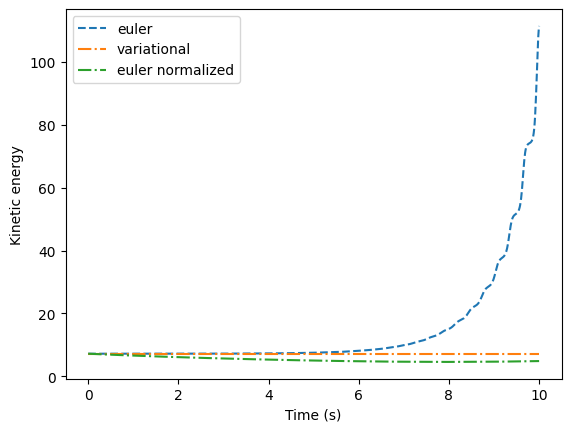

In [25]:
# plot kinetic energy
plt.figure()
plt.plot(t1euler, k1euler, '--', label='euler')
plt.plot(t1vi, k1vi, '-.', label='variational')
plt.plot(t1euler, k1norm, '-.', label='euler normalized')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Kinetic energy')